# Question 4: Retrieval-Augmented Generation (RAG) System

Implements a RAG pipeline using HotpotQA dataset with BM25 (sparse) and SBERT (dense) retrievers, FLAN-T5 generator, and comprehensive evaluation.

## Step 2: Data Loading and Corpus Construction

Loads HotpotQA validation split and builds ~52K document corpus by flattening Wikipedia paragraphs from context.

In [ ]:
import torch
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm

# 1. Load Dataset
print("Loading HotpotQA dataset (distractor, validation)...")
dataset = load_dataset("hotpot_qa", "distractor", split="validation")

print(f"Dataset loaded. Size: {len(dataset)}")

# 2. Create Knowledge Base (Corpus)
# HotpotQA 'context' is a list of [title, sentences]. 

corpus = []
doc_ids = []

seen_titles = set()

print("Building Corpus...")
for row in tqdm(dataset):
    context = row['context'] # List of [title, sentences]
    for title, sentences in zip(context['title'], context['sentences']):
        if title not in seen_titles:
            text = " ".join(sentences)
            corpus.append(text)
            doc_ids.append(title)
            seen_titles.add(title)

print(f"Corpus created. Total unique documents: {len(corpus)}")
print("Sample Document:", corpus[0])

Loading HotpotQA dataset (distractor, validation)...
Dataset loaded. Size: 7405
Building Corpus...
Dataset loaded. Size: 7405
Building Corpus...


100%|██████████| 7405/7405 [00:01<00:00, 5775.78it/s]

Corpus created. Total unique documents: 66581
Sample Document: Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood.  The film concerns the period in Wood's life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau.  Sarah Jessica Parker, Patricia Arquette, Jeffrey Jones, Lisa Marie, and Bill Murray are among the supporting cast.


## Step 3: BM25 Sparse Retrieval

Implements BM25Okapi indexing with whitespace tokenization for keyword-based document retrieval.

In [ ]:
from rank_bm25 import BM25Okapi

# 1. Tokenization
print("Tokenizing corpus...")
tokenized_corpus = [doc.split(" ") for doc in corpus]

# 2. Indexing
print("Indexing with BM25...")
bm25 = BM25Okapi(tokenized_corpus)
print("Indexing complete.")

# 3. Retrieval Function
def retrieve(query, top_k=5):
    """
    Retrieves the most relevant top_k documents for the given query.
    """
    tokenized_query = query.split(" ")
    # Get top-k documents
    top_docs = bm25.get_top_n(tokenized_query, corpus, n=top_k)
    return top_docs



Tokenizing corpus...
Indexing with BM25...
Indexing with BM25...
Indexing complete.
Indexing complete.


## Step 4: SBERT Dense Retrieval

Uses `all-MiniLM-L6-v2` (384-dim) to encode corpus and perform semantic search with cosine similarity.

In [ ]:
# --- DENSE RETRIEVER (SENTENCE-BERT) SETUP ---
from sentence_transformers import SentenceTransformer, util
import torch
import time

print("="*50)
print("STEP 2.5: DENSE RETRIEVER (SBERT) SETUP")
print("="*50)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Load Model
# 'all-MiniLM-L6-v2': Fast and high-performance small model
sbert_model_name = 'all-MiniLM-L6-v2'
print(f"Loading SBERT model ({sbert_model_name})...")
sbert_model = SentenceTransformer(sbert_model_name, device=device)

# 2. Encode Corpus 
# Converting texts to vectors
if 'corpus' not in locals():
    print("ERROR: 'corpus' variable not found. Please run the corpus building step first.")
else:
    print("Encoding corpus (This may take a while)...")
    start_time = time.time()

    corpus_embeddings = sbert_model.encode(corpus, convert_to_tensor=True, show_progress_bar=True)

    end_time = time.time()
    print(f"Encoding completed. Time: {end_time - start_time:.2f} sec")
    print(f"Embedding shape: {corpus_embeddings.shape}")

# 3. Dense Retrieval Function
def retrieve_dense(query, top_k=5):
    """
    Performs semantic search using SBERT.
    """
    # Encode query
    query_embedding = sbert_model.encode(query, convert_to_tensor=True)
    
    # Calculate Cosine Similarity
    # Compares query vector with all corpus vectors
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    
    # Find top_k highest scoring documents
    top_results = torch.topk(cos_scores, k=top_k)
    
    # Return document texts
    results = []
    for idx in top_results.indices:
        results.append(corpus[idx.item()])
        
    return results




STEP 2.5: DENSE RETRIEVER (SBERT) SETUP
Using device: cuda
Loading SBERT model (all-MiniLM-L6-v2)...
STEP 2.5: DENSE RETRIEVER (SBERT) SETUP
Using device: cuda
Loading SBERT model (all-MiniLM-L6-v2)...
Encoding corpus (This may take a while)...
Encoding corpus (This may take a while)...


Batches:   0%|          | 0/2081 [00:00<?, ?it/s]

Encoding completed. Time: 96.48 sec
Embedding shape: torch.Size([66581, 384])


## Step 5: RAG Pipeline with FLAN-T5

Integrates retrieval (BM25/Dense) with FLAN-T5-Base generation using context injection and beam search.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

print("="*50)
print("STEP 3: RAG PIPELINE WITH FLAN-T5 (BASE)")
print("="*50)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_name = "google/flan-t5-base" 

print(f"Loading model: {model_name}...")
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
    print("  FLAN-T5-Base successfully loaded.")
except Exception as e:
    print(f"ERROR: Failed to load base model ({e}). Please check internet connection.")



def retrieve_and_generate(question, top_k=5, method='bm25'):
    """
    Retrieves top_k documents and generates answer.
    Returns both the answer and retrieved documents for verification.
    """
    
    # A. RETRIEVAL
    if method == 'dense':
        retrieved_docs = retrieve_dense(question, top_k=top_k)
    else:
        tokenized_query = question.lower().split(" ")
        retrieved_docs = bm25.get_top_n(tokenized_query, corpus, n=top_k)
    
    # B. GENERATION
    context = " ".join(retrieved_docs)
    prompt = f"Context: {context}\n\nQuestion: {question}\n\nAnswer:"
    
    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True).to(device)
    
    outputs = model.generate(
        **inputs, 
        max_new_tokens=50, 
        num_beams=5,       
        early_stopping=True
    )
    
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return answer, retrieved_docs

# --- TEST THE PIPELINE ---
test_q = "Who are the vocals of Linkin Park?"
print(f"\nTest Question: {test_q}")

# Using top_k=5 for broader context
ans, docs = retrieve_and_generate(test_q, top_k=5, method='dense')

print(f"Model Answer: {ans}\n")

STEP 3: RAG PIPELINE WITH FLAN-T5 (BASE)
Loading model: google/flan-t5-base...
✓ FLAN-T5-Base successfully loaded.

Question: Who are the vocals of Linkin Park?
✓ FLAN-T5-Base successfully loaded.

Question: Who are the vocals of Linkin Park?
✅ Model Answer: Chester Bennington

--- Documents Read by Model (Evidence) ---
[1] ✅ FOUND! Michael Kenji Shinoda ( , born February 11, 1977) is an American musician, songwriter, record produc...
[2] ✅ FOUND! Chester Charles Bennington (March 20, 1976 – July 20, 2017) was an American singer and songwriter.  ...
[3] ✅ FOUND! American rock band Linkin Park has recorded material for seven studio albums, the most recent being ...
[4] ✅ FOUND! "Heavy" is a song by American rock band Linkin Park, featuring guest vocals from American singer Kii...
[5] ✅ FOUND! "Talking to Myself" is a song by American rock band Linkin Park.  The song is the second single from...
✅ Model Answer: Chester Bennington

--- Documents Read by Model (Evidence) ---
[1] ✅ FOUND! M

## Step 6: Comprehensive Evaluation

Evaluates 200 samples with retrieval metrics (Precision@k, Recall@k) and generation metrics (BLEU-1, ROUGE-L, BERTScore).

Comparison Test Set: 200 samples selected.
Retrieval Pool Size: 66581 unique documents
Test/Pool Ratio: 0.60%

=== COMPREHENSIVE EVALUATION ===
Evaluating Retrieval Metrics: Precision@k, Recall@k
Evaluating Generation Metrics: BLEU, ROUGE-L, BERTScore

--- Evaluating Method: BM25 ---


BM25 Evaluation: 100%|██████████| 200/200 [02:03<00:00,  1.62it/s]




BM25 Results:
  Retrieval Metrics:
    Precision@1: 0.1850
    Precision@3: 0.0867
    Precision@5: 0.0590
    Recall@1: 0.0925
    Recall@3: 0.1300
    Recall@5: 0.1475
  Generation Metrics:
    BLEU-1: 0.1820
    ROUGE-L: 0.2108
    BERTScore: 0.8734
  Generation Issues:
    Empty generations: 3/200 (1.5%)

--- Evaluating Method: DENSE ---


DENSE Evaluation: 100%|██████████| 200/200 [00:57<00:00,  3.49it/s]




DENSE Results:
  Retrieval Metrics:
    Precision@1: 0.7300
    Precision@3: 0.3733
    Precision@5: 0.2440
    Recall@1: 0.3650
    Recall@3: 0.5600
    Recall@5: 0.6100
  Generation Metrics:
    BLEU-1: 0.3483
    ROUGE-L: 0.3603
    BERTScore: 0.9094
  Generation Issues:
    Empty generations: 2/200 (1.0%)

=== COMPLETE EVALUATION RESULTS ===
Method  Precision@1  Precision@3  Precision@5  Recall@1  Recall@3  Recall@5   BLEU-1  ROUGE-L  BERTScore
  BM25        0.185     0.086667        0.059    0.0925      0.13    0.1475 0.181996 0.210802   0.873416
 DENSE        0.730     0.373333        0.244    0.3650      0.56    0.6100 0.348312 0.360340   0.909450

✓ Retrieval metrics plot saved as 'retrieval_metrics_comparison.png'

✓ Retrieval metrics plot saved as 'retrieval_metrics_comparison.png'


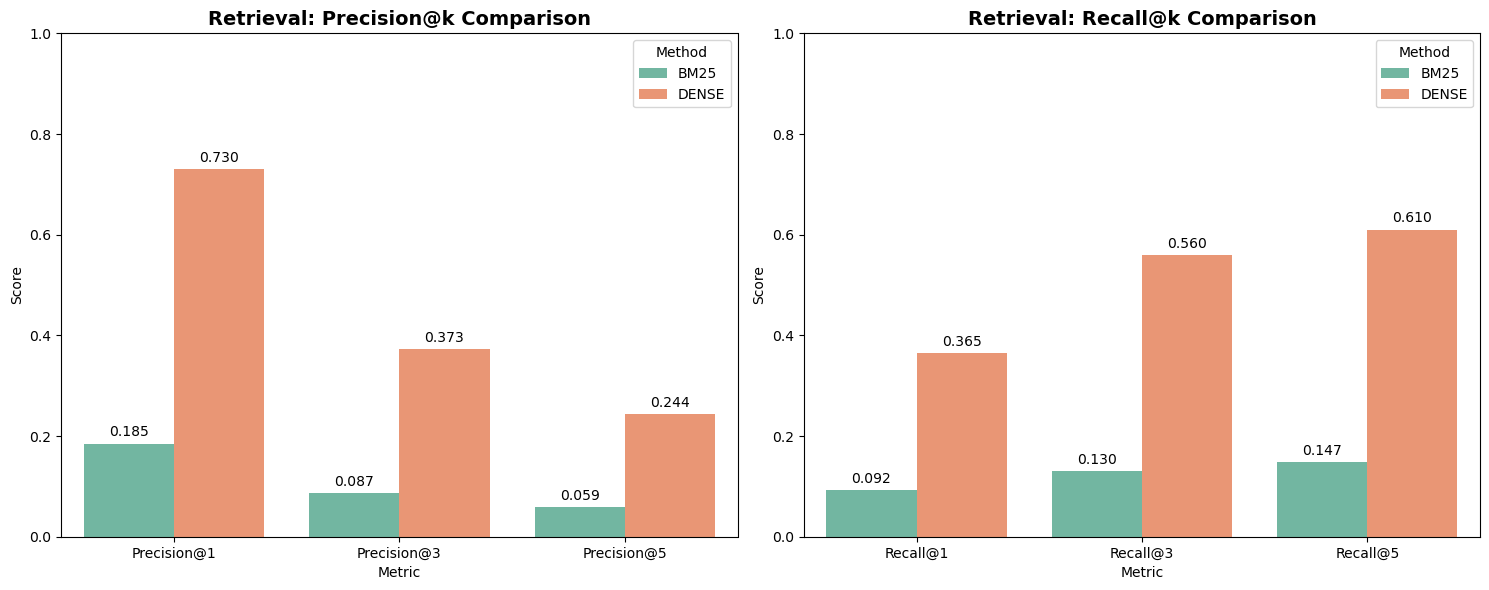

✓ Generation metrics plot saved as 'generation_metrics_comparison.png'


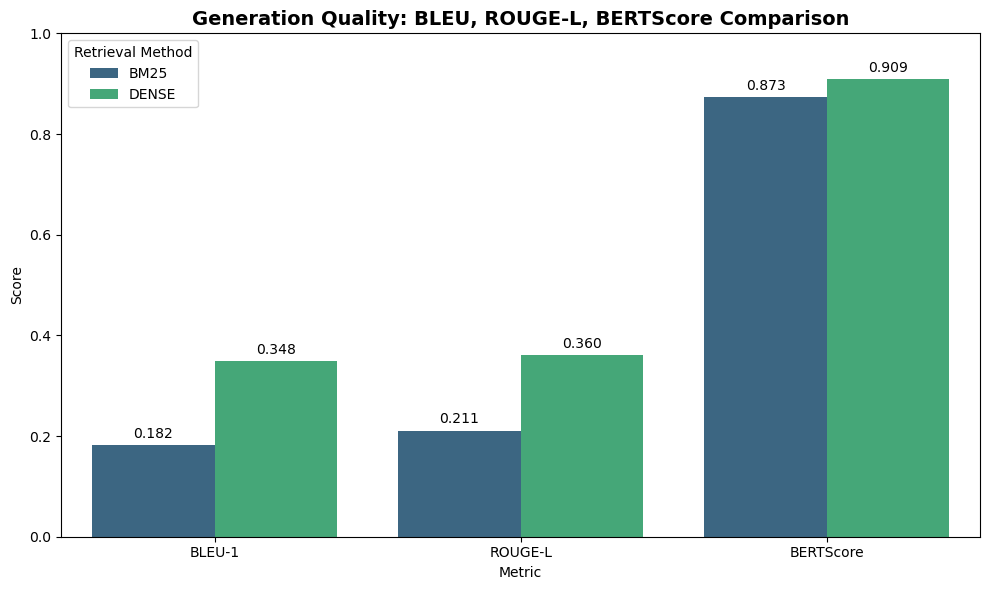

✓ Complete evaluation plot saved as 'rag_complete_evaluation.png'


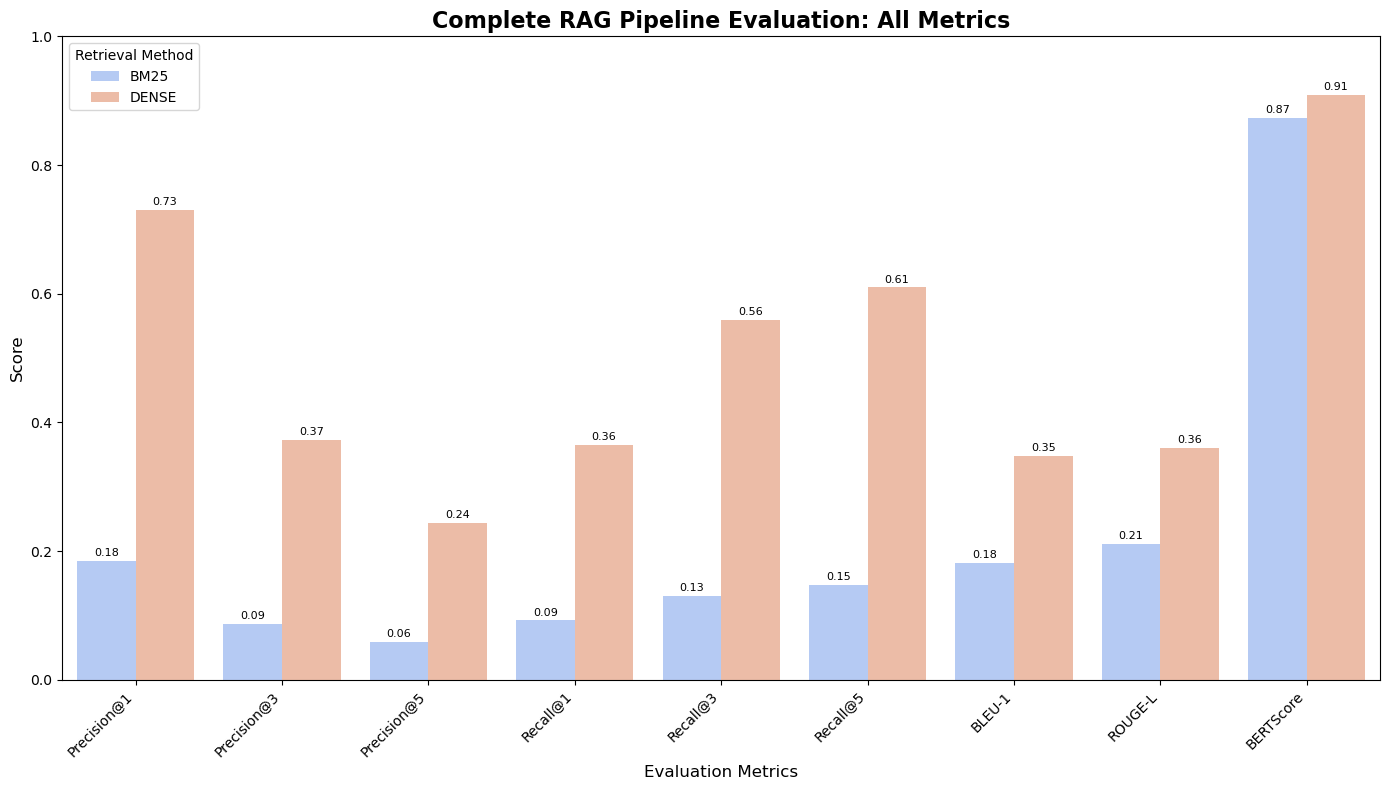


=== EVALUATION SUMMARY ===

✓ Evaluated 2 retrieval methods on 200 test samples
✓ Retrieval metrics: Precision@k and Recall@k (k=1,3,5)
✓ Generation metrics: BLEU-1, ROUGE-L, BERTScore
✓ All visualizations saved successfully

Evaluation complete!


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import evaluate

# Load metrics if not already defined
try:
    bleu
except NameError:
    print("Loading metrics...")
    bleu = evaluate.load('bleu')
    rouge = evaluate.load('rouge')
    bertscore = evaluate.load('bertscore')

np.random.seed(42)
indices = np.random.choice(len(dataset), 200, replace=False)
comparison_samples = dataset.select(indices)

print(f"Comparison Test Set: {len(comparison_samples)} samples selected.")
print(f"Retrieval Pool Size: {len(corpus)} unique documents")
print(f"Test/Pool Ratio: {len(comparison_samples)/len(corpus)*200:.2f}%")

# Helper function to calculate Precision@k and Recall@k
def calculate_retrieval_metrics(retrieved_docs, ground_truth_docs, k):
    """
    Calculate Precision@k and Recall@k for retrieval.
    
    Args:
        retrieved_docs: List of retrieved document titles (top-k)
        ground_truth_docs: List of relevant document titles from supporting_facts
        k: Number of top documents to consider
        
    Returns:
        precision: Precision@k score
        recall: Recall@k score
    """
    retrieved_set = set(retrieved_docs[:k])
    relevant_set = set(ground_truth_docs)
    
    if len(relevant_set) == 0:
        return 0.0, 0.0
    
    hits = len(retrieved_set.intersection(relevant_set))
    
    precision = hits / k if k > 0 else 0.0
    recall = hits / len(relevant_set) if len(relevant_set) > 0 else 0.0
    
    return precision, recall

# Preparation for metrics - expanded metrics
methods = ['bm25', 'dense']
results = {
    'Method': [],
    'Precision@1': [],
    'Precision@3': [],
    'Precision@5': [],
    'Recall@1': [],
    'Recall@3': [],
    'Recall@5': [],
    'BLEU-1': [],
    'ROUGE-L': [],
    'BERTScore': []
}

print("\n=== COMPREHENSIVE EVALUATION ===")
print("Evaluating Retrieval Metrics: Precision@k, Recall@k")
print("Evaluating Generation Metrics: BLEU, ROUGE-L, BERTScore")
print("="*50)

for method in methods:
    print(f"\n--- Evaluating Method: {method.upper()} ---")
    
    # Retrieval metrics storage
    precision_at_1 = []
    precision_at_3 = []
    precision_at_5 = []
    recall_at_1 = []
    recall_at_3 = []
    recall_at_5 = []
    
    # Generation metrics storage
    predictions = []
    references = []
    empty_generation_count = 0  # Track empty generations
    
    for row in tqdm(comparison_samples, desc=f"{method.upper()} Evaluation"):
        question = row['question']
        ground_truth = row['answer']
        
        # Get supporting facts (ground truth relevant documents)
        supporting_facts = row['supporting_facts']
        relevant_doc_titles = [fact[0] for fact in zip(supporting_facts['title'], supporting_facts['sent_id'])]
        relevant_doc_titles = list(set(relevant_doc_titles))  # Remove duplicates
        
        # RAG Pipeline with document titles
        if method == 'dense':
            retrieved_docs_texts = retrieve_dense(question, top_k=5)
        else:
            tokenized_query = question.lower().split(" ")
            retrieved_docs_texts = bm25.get_top_n(tokenized_query, corpus, n=5)
        
        # Map retrieved documents back to their titles for retrieval metrics
        retrieved_titles = []
        for doc_text in retrieved_docs_texts:
            # Find the title by matching the document text to corpus
            try:
                doc_idx = corpus.index(doc_text)
                retrieved_titles.append(doc_ids[doc_idx])
            except ValueError:
                pass  # Document not found in corpus
        
        # Calculate Precision@k and Recall@k
        p1, r1 = calculate_retrieval_metrics(retrieved_titles, relevant_doc_titles, k=1)
        p3, r3 = calculate_retrieval_metrics(retrieved_titles, relevant_doc_titles, k=3)
        p5, r5 = calculate_retrieval_metrics(retrieved_titles, relevant_doc_titles, k=5)
        
        precision_at_1.append(p1)
        precision_at_3.append(p3)
        precision_at_5.append(p5)
        recall_at_1.append(r1)
        recall_at_3.append(r3)
        recall_at_5.append(r5)
        
        # Generation part
        context = " ".join(retrieved_docs_texts[:5])
        prompt = f"Context: {context}\n\nQuestion: {question}\n\nAnswer:"
        
        inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True).to(device)
        outputs = model.generate(**inputs, max_new_tokens=50, num_beams=5, early_stopping=True)
        generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Handle empty generations (causes BERTScore warnings)
        if not generated or generated.strip() == "":
            generated = "unknown"  # Default fallback answer
            empty_generation_count += 1
        
        predictions.append(generated)
        references.append(ground_truth)
    
    # Aggregate retrieval metrics
    avg_precision_at_1 = np.mean(precision_at_1)
    avg_precision_at_3 = np.mean(precision_at_3)
    avg_precision_at_5 = np.mean(precision_at_5)
    avg_recall_at_1 = np.mean(recall_at_1)
    avg_recall_at_3 = np.mean(recall_at_3)
    avg_recall_at_5 = np.mean(recall_at_5)
    
    # Calculate generation metrics
    bleu1_score = bleu.compute(predictions=predictions, references=references, max_order=1)['bleu']
    rouge_l_score = rouge.compute(predictions=predictions, references=references)['rougeL']
    bert_score_res = bertscore.compute(predictions=predictions, references=references, lang="en")
    bert_f1 = np.mean(bert_score_res['f1'])
    
    # Store results
    results['Method'].append(method.upper())
    results['Precision@1'].append(avg_precision_at_1)
    results['Precision@3'].append(avg_precision_at_3)
    results['Precision@5'].append(avg_precision_at_5)
    results['Recall@1'].append(avg_recall_at_1)
    results['Recall@3'].append(avg_recall_at_3)
    results['Recall@5'].append(avg_recall_at_5)
    results['BLEU-1'].append(bleu1_score)
    results['ROUGE-L'].append(rouge_l_score)
    results['BERTScore'].append(bert_f1)
    
    print(f"\n{method.upper()} Results:")
    print(f"  Retrieval Metrics:")
    print(f"    Precision@1: {avg_precision_at_1:.4f}")
    print(f"    Precision@3: {avg_precision_at_3:.4f}")
    print(f"    Precision@5: {avg_precision_at_5:.4f}")
    print(f"    Recall@1: {avg_recall_at_1:.4f}")
    print(f"    Recall@3: {avg_recall_at_3:.4f}")
    print(f"    Recall@5: {avg_recall_at_5:.4f}")
    print(f"  Generation Metrics:")
    print(f"    BLEU-1: {bleu1_score:.4f}")
    print(f"    ROUGE-L: {rouge_l_score:.4f}")
    print(f"    BERTScore: {bert_f1:.4f}")
    print(f"  Generation Issues:")
    print(f"    Empty generations: {empty_generation_count}/{len(comparison_samples)} ({empty_generation_count/len(comparison_samples)*100:.1f}%)")

# Create comprehensive results table
df_results = pd.DataFrame(results)
print("\n" + "="*80)
print("=== COMPLETE EVALUATION RESULTS ===")
print("="*80)
print(df_results.to_string(index=False))

# Visualization 1: Retrieval Metrics Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Precision@k comparison
precision_data = df_results[['Method', 'Precision@1', 'Precision@3', 'Precision@5']]
precision_melted = precision_data.melt(id_vars='Method', var_name='Metric', value_name='Score')

sns.barplot(data=precision_melted, x='Metric', y='Score', hue='Method', palette='Set2', ax=axes[0])
axes[0].set_title('Retrieval: Precision@k Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.0)
axes[0].legend(title='Method')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f', padding=3)

# Recall@k comparison
recall_data = df_results[['Method', 'Recall@1', 'Recall@3', 'Recall@5']]
recall_melted = recall_data.melt(id_vars='Method', var_name='Metric', value_name='Score')

sns.barplot(data=recall_melted, x='Metric', y='Score', hue='Method', palette='Set2', ax=axes[1])
axes[1].set_title('Retrieval: Recall@k Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.0)
axes[1].legend(title='Method')
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.savefig('retrieval_metrics_comparison.png', dpi=300, bbox_inches='tight')
print("\n  Retrieval metrics plot saved as 'retrieval_metrics_comparison.png'")
plt.show()

# Visualization 2: Generation Metrics Comparison
plt.figure(figsize=(10, 6))
generation_data = df_results[['Method', 'BLEU-1', 'ROUGE-L', 'BERTScore']]
generation_melted = generation_data.melt(id_vars='Method', var_name='Metric', value_name='Score')

ax = sns.barplot(data=generation_melted, x='Metric', y='Score', hue='Method', palette='viridis')
ax.set_title('Generation Quality: BLEU, ROUGE-L, BERTScore Comparison', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.0)
plt.legend(title='Retrieval Method')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.savefig('generation_metrics_comparison.png', dpi=300, bbox_inches='tight')
print("  Generation metrics plot saved as 'generation_metrics_comparison.png'")
plt.show()

# Visualization 3: Joint Performance Overview
plt.figure(figsize=(14, 8))
all_metrics_melted = df_results.melt(id_vars='Method', var_name='Metric', value_name='Score')

ax = sns.barplot(data=all_metrics_melted, x='Metric', y='Score', hue='Method', palette='coolwarm')
ax.set_title('Complete RAG Pipeline Evaluation: All Metrics', fontsize=16, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.set_xlabel('Evaluation Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Retrieval Method', fontsize=10)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=2, fontsize=8)

plt.tight_layout()
plt.savefig('rag_complete_evaluation.png', dpi=300, bbox_inches='tight')
print("  Complete evaluation plot saved as 'rag_complete_evaluation.png'")
plt.show()




## Step 7: Qualitative Analysis

Identifies 3 faithful generation and 3 hallucination examples to analyze RAG success/failure patterns.

In [ ]:
print("Searching for Qualitative Examples (Faithful vs Hallucination)...")
print("Looking for 3 examples of each type...\n")

faithful_examples = []
hallucination_examples = []

analysis_samples = dataset.select(range(50, 250)) 

for row in tqdm(analysis_samples, desc="Analyzing Examples"):
    if len(faithful_examples) >= 3 and len(hallucination_examples) >= 3:
        break
        
    question = row['question']
    ground_truth = row['answer']
    
    # Generating
    generated, docs = retrieve_and_generate(question, top_k=5, method='dense')
    context_text = " ".join(docs)
    
    # Calculating ROUGE for this single example
    scores = rouge.compute(predictions=[generated], references=[ground_truth])
    rouge_l = scores['rougeL']
    
    # Checking Faithful
    if len(faithful_examples) < 3:
        if rouge_l > 0.4 or (ground_truth.lower() in context_text.lower() and rouge_l > 0.2):
            faithful_examples.append({
                'question': question,
                'context': context_text[:400],
                'ground_truth': ground_truth,
                'generated': generated,
                'rouge_l': rouge_l
            })
            continue

    # Checking Hallucination
    if len(hallucination_examples) < 3:
        if rouge_l < 0.15 and ground_truth.lower() not in context_text.lower() and len(generated) > 3:
            hallucination_examples.append({
                'question': question,
                'context': context_text[:400],
                'ground_truth': ground_truth,
                'generated': generated,
                'rouge_l': rouge_l
            })

# Displaying Faithful Examples
print("\n" + "="*80)
print("✅ FAITHFUL GENERATION EXAMPLES (3)")
print("="*80)

for i, example in enumerate(faithful_examples, 1):
    print(f"\n{'='*40}")
    print(f"FAITHFUL EXAMPLE #{i}")
    print(f"{'='*40}")
    print(f"Question: {example['question']}")
    print(f"\nRetrieved Context (excerpt):")
    print(f"  {example['context']}...")
    print(f"\nGround Truth Answer: {example['ground_truth']}")
    print(f"Generated Answer: {example['generated']}")
    print(f"ROUGE-L Score: {example['rouge_l']:.3f}")
    
    if example['ground_truth'].lower() in example['context'].lower():
        print("✅ Verification: Ground truth FOUND in retrieved context")
    else:
        print("⚠️  Verification: Ground truth not in excerpt (may be further in context)")
    
    print(f"Status: ✅ FAITHFUL - Model correctly used retrieved information")

# Displayinng Hallucination Examples
print("\n\n" + "="*80)
print("❌ HALLUCINATION / ERROR EXAMPLES (3)")
print("="*80)

for i, example in enumerate(hallucination_examples, 1):
    print(f"\n{'='*40}")
    print(f"HALLUCINATION EXAMPLE #{i}")
    print(f"{'='*40}")
    print(f"Question: {example['question']}")
    print(f"\nRetrieved Context (excerpt):")
    print(f"  {example['context']}...")
    print(f"\nGround Truth Answer: {example['ground_truth']}")
    print(f"Generated Answer: {example['generated']}")
    print(f"ROUGE-L Score: {example['rouge_l']:.3f}")
    
    if example['ground_truth'].lower() not in example['context'].lower():
        print("❌ Problem: Ground truth NOT in retrieved context → Retrieval failure")
    else:
        print("⚠️  Problem: Context has info but generation failed → Model error")
    
    print(f"Status: ❌ HALLUCINATION/ERROR - Model failed to provide correct answer")

# Summary Statistics
print("\n\n" + "="*80)
print("QUALITATIVE ANALYSIS SUMMARY")
print("="*80)
print(f"✅ Faithful Examples Found: {len(faithful_examples)}")
print(f"   Average ROUGE-L: {np.mean([ex['rouge_l'] for ex in faithful_examples]):.3f}")
print(f"\n❌ Hallucination Examples Found: {len(hallucination_examples)}")
print(f"   Average ROUGE-L: {np.mean([ex['rouge_l'] for ex in hallucination_examples]):.3f}")

print(f"\nROUGE-L Gap: {np.mean([ex['rouge_l'] for ex in faithful_examples]) - np.mean([ex['rouge_l'] for ex in hallucination_examples]):.3f}")




Searching for Qualitative Examples (Faithful vs Hallucination)...
Looking for 3 examples of each type...



Analyzing Examples:   4%|▎         | 7/200 [00:02<01:15,  2.55it/s]


✅ FAITHFUL GENERATION EXAMPLES (3)

FAITHFUL EXAMPLE #1
Question: In 1991 Euromarché was bought by a chain that operated how any hypermarkets at the end of 2016?

Retrieved Context (excerpt):
  Euromarché ("Euromarket") was a French hypermarket chain.  The first store opened in 1968 in Saint-Michel-sur-Orge.  In June 1991, the group was rebought by its rival, Carrefour, for 5,2 billion francs. Carrefour S.A. (] ) is a French multinational retailer headquartered in Boulogne Billancourt, France, in the Hauts-de-Seine Department near Paris.  It is one of the largest hypermarket chains in th...

Ground Truth Answer: 1,462
Generated Answer: 1,462
ROUGE-L Score: 1.000
⚠️  Verification: Ground truth not in excerpt (may be further in context)
Status: ✅ FAITHFUL - Model correctly used retrieved information

FAITHFUL EXAMPLE #2
Question: What race track in the midwest hosts a 500 mile race eavery May?

Retrieved Context (excerpt):
  The 41st International 500-Mile Sweepstakes was held at the In